### Code to process the downloaded HCHO data 

In [12]:
import xarray as xr
import numpy as np
import matplotlib as mpl
import numpy as np
import xesmf as xe
import glob 
import os

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

# load additional function from LTPY
%run ../LTPY_functions.ipynb

In [13]:
HCHO_dir = '/exports/geos.ed.ac.uk/palmer_group/managed/s0677837/measurements/satellite/TROPOMI/HCHO/'

In [14]:
def subset_tropomi_data(DATADIR, lat_resn, lon_resn, lat_min, lat_max, lon_min, lon_max, var_name):
    # A function that reads in all Tropomi files in a directory and subsets and regrids them to the required lat and lon extents, 
    # and for the defined pixel resolution
    # example usage: subset_tropomi_data(DATADIR, 5.5, 7.0, lat_min, lat_max, lon_min, lon_max)
    
    # creating a new grid that all timesteps of the irregular grid will be interpolated to
    # Calculating the new grid spacings
    lat_num = calculate_grid_spacing(lat_min, lat_max, lat_resn)
    lon_num = calculate_grid_spacing(lon_min, lon_max, lon_resn)

    # creating a 7.0 x 5.5 km grid (or any defined lon_resn x lat_resn)
    output_latitudes = np.linspace(lat_min,lat_max, lat_num)
    output_longitudes = np.linspace(lon_min, lon_max, lon_num)
    
    
    # defining the output grid for the xarray regridding step
    output_grid = xr.Dataset({'lat': (['lat'], output_latitudes), 'lon': (['lon'], output_longitudes)})
    
    # an array of all the subset and regridded Tropomi data
    ds_subset_all = []
    counter = 0 
    for filename in glob.glob(DATADIR + 'S5P*'):
        #print the progress periodically when testing
        if counter % 10 == 0:
            print (counter, filename)
        
        #print (counter, filename)
        
        # opening the files one by one (it crashes if trying to add them all to the same array due to the large file size)
        ds = xr.open_mfdataset(filename, combine='nested', group='PRODUCT')

        # subsetting the data
        ds_subset0 = generate_geographical_subset(xarray=ds, 
                                                 latmin=lat_min, 
                                                 latmax=lat_max, 
                                                 lonmin=lon_min, 
                                                 lonmax=lon_max)
        

        # assignment of latitude and longitude is required for the HCHO data, but not for the CH4 data, not sure why as they seem to have the same format. 
        ds_subset0 = ds_subset0.set_coords(('latitude','longitude'))
        
        # load the subset
        ds_subset = ds_subset0[var_name].load()
        
        # some files have no timesteps so the regridding step doesn't work. Only regridding if there are more than 0 timesteps.
        if len(ds_subset > 0):

            # using xesmf function to calculate the regridding matrix using nearest neighbour method. Periodic = False defined for irregular grid.
            # need to run the precision product also and use it to mask the data (0.5 for HCHO?)
            regridder = xe.Regridder(ds_subset[0], output_grid, 'nearest_s2d', periodic=False)

            # regridding the data
            ds_new = regridder(ds_subset)

            # appending the regridded dataset to an array (this will later be concatenated - note that the dates are not currently in the right order)
            ds_subset_all.append(ds_new)
        
        counter = counter + 1
        
    return (ds_subset_all)
    

In [15]:
# Calculating the new grid spacings. Using 7km across track and 5.5km along track as this is the highest resolution for the scan direction (but not representative of all the data)

def calculate_grid_spacing(l_min, l_max, res):
    # returns the number of lats/lons to be included in each dimension of the new grid
    # usage example: calculate_grid_spacing(latitudes, 5.5)
    # where array is the range of lats/lons in degrees
    # and res is the required resolution of the output grid
    
    # difference between the maximum and min lat/lon values of the range
    l_diff = l_max-l_min
    
    # range in km, 1 degree ~ 111.139 km at the equator
    l_dist = l_diff*111.139  
    
    # number of pixels with specified resolution that will fit into this extent
    # rounding to the nearest number
    num = int(round(l_dist/res,0))
    
    return num

In [16]:
def finalise_outputs(ds, var_name, out_file, ddir):
    # concatenating the array of xarrays, these are not currently in the right date order, so also sorting them by date
    ds_final = xr.concat(ds, dim='time')
    
    # sorting into ascending date range
    ds_sorted = ds_final.sortby('time', ascending=True)
    
    # assigning new var name
    ds_new = ds_sorted.to_dataset(name = var_name)
    
    print ('saving to file: ' + out_file)
    ds_new.to_netcdf(ddir + out_file)
    
    return ds_new

In [17]:
def remove_repeated_timesteps(ds, var_name):
    # remove repeated time steps in an xarray dataset
    # example usage:  ds_methane_new = remove_repeated_timesteps(ds_methane, 'Methane (ppb)')
    # This is currently used in the next code,Analyse_L2_Tropomi_CH4.ipynb, but could be done here instead
    
    da = ds[var_name].copy()

    # first remove all dates with no data at all
    da = da.dropna(dim='time', how='all')

    print ('Empty time steps (these have been removed): ' + str(len(ds[var_name]) - len(da)))

    for i in range(len(da)-1):
        # checking if the timestep is repeated
        if da[i].time.values == da[i+1].time.values:
            #print ('Matched at: ' + str(i) + ' and ' + str(ds[i].time.values))

            # merge the data from these two dates
            da1 = da[i]
            da2 = da[i+1]
            #print (ds1.time.values, ds2.time.values)
            ds = xr.merge([da1,da2])
            da[i] = ds[var_name]
        
    # drop duplicates along the time dimension, keeping the first date which contains the merged information
    _, index = np.unique(da['time'], return_index=True)
    da2 = da.isel(time=index)
    ds_new = da2.to_dataset(name = var_name)
    ds_new

    return ds_new

### Covering the full Cuvette Centrale region
lat_min = -5.0
lat_max = 3.5
lon_min = 15.0
lon_max = 23.0

Sentinel-5P TROPOMI variables have the following dimensions:
- corner: pixel corner index
- ground_pixel: the number of spectra in a measurement / across-track dimension index
- layer: this dimension indicates the vertical grid of profile variables
- scanline: the number of measurements in the granule / along-track dimension index
- time: time reference for the data

In [18]:
# Extent of the Cuvette Centrale peatlands
lat_min = -5.0
lat_max = 3.5
lon_min = 15.0
lon_max = 23.0

In [ ]:
%%time
# using a higher resolution grid than the base Tropomi resolution (approx 1 x 1 km) to account for pixels not being exactly aligned between timesteps
# running seperately for each year, month, day folder
y= '2021'
m = '01'
d = '07'

#DATADIR = HCHO_dir + y + '/' + m + '/' + d + '/'

DATADIR = '/exports/geos.ed.ac.uk/palmer_group/managed/s0677837/Peatlands/TROPOMI/HCHO/CC_RPRO/'
DATADIR_OFFL = '/exports/geos.ed.ac.uk/palmer_group/managed/s0677837/Peatlands/TROPOMI/HCHO/CC/'
DATADIR2 = '/exports/geos.ed.ac.uk/palmer_group/managed/s0677837/Peatlands/TROPOMI/HCHO/gridded/'

print (DATADIR)
#RPRO Version
#ds_all = subset_tropomi_data(DATADIR, 1.0, 1.0, lat_min, lat_max, lon_min, lon_max, 'formaldehyde_tropospheric_vertical_column')
#finalise_outputs(ds_all, 'HCHO (mol m-2)', 'HCHO_RPRO_ts_1km.nc', DATADIR2)

# OFFL version
ds_all = subset_tropomi_data(DATADIR_OFFL, 1.0, 1.0, lat_min, lat_max, lon_min, lon_max, 'formaldehyde_tropospheric_vertical_column')
finalise_outputs(ds_all, 'HCHO (mol m-2)', 'HCHO_OFFL_ts_1km.nc', DATADIR2)


ds_all


# next steps are in the code (combining dates, and final analysis): Analyse_L2_Tropomi_HCHO.ipynb

In [ ]:
# precision data
ds_prec = subset_tropomi_data(DATADIR_OFFL, 1.0, 1.0, lat_min, lat_max, lon_min, lon_max, 'formaldehyde_tropospheric_vertical_column_precision')
finalise_outputs(ds_prec, 'HCHO error (mol m-2)', 'HCHO_OFFL_precision_ts_1km.nc', DATADIR2)

In [ ]:
# qa value for masking
ds_qa = subset_tropomi_data(DATADIR_OFFL, 1.0, 1.0, lat_min, lat_max, lon_min, lon_max, 'qa_value')
finalise_outputs(ds_qa, 'qa value', 'HCHO_OFFL_qa_value_ts_1km.nc', DATADIR2)

In [147]:
#finalise_outputs(ds_all, 'HCHO (mol m-2)', 'HCHO_OFFL_' + y + m + d + '_ts_1km.nc', DATADIR2)

saving to file: HCHO_OFFL_20210107_ts_1km.nc


<xarray.Dataset>
Dimensions:         (lat: 945, lon: 889, time: 53)
Coordinates:
  * time            (time) datetime64[ns] 2018-12-04 2018-12-05 ... 2019-05-07
  * lon             (lon) float64 15.0 15.01 15.02 15.03 ... 22.98 22.99 23.0
  * lat             (lat) float64 -5.0 -4.991 -4.982 -4.973 ... 3.482 3.491 3.5
Data variables:
    HCHO (mol m-2)  (time, lat, lon) float64 nan nan nan nan ... 0.0 0.0 0.0 0.0

In [148]:
ds = xr.open_dataset(DATADIR2 + 'HCHO_OFFL_' + y + m + d + '_ts_1km.nc')
ds

<xarray.Dataset>
Dimensions:         (lat: 945, lon: 889, time: 53)
Coordinates:
  * time            (time) datetime64[ns] 2018-12-04 2018-12-05 ... 2019-05-07
  * lon             (lon) float64 15.0 15.01 15.02 15.03 ... 22.98 22.99 23.0
  * lat             (lat) float64 -5.0 -4.991 -4.982 -4.973 ... 3.482 3.491 3.5
Data variables:
    HCHO (mol m-2)  (time, lat, lon) float64 ...

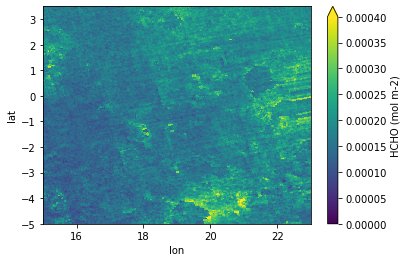

In [184]:
ds['HCHO (mol m-2)'].mean(dim='time').plot(vmin=0, vmax = 0.0004, cmap='viridis')

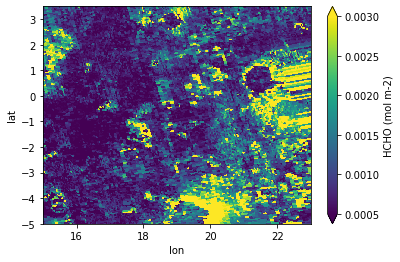

In [188]:
ds['HCHO (mol m-2)'].max(dim='time').plot(vmin=0.0005, vmax = 0.003, cmap='viridis')

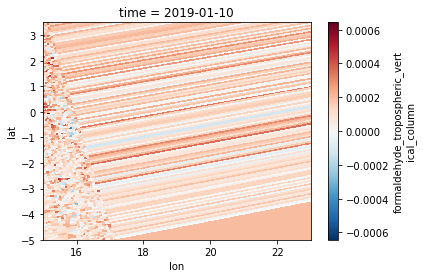

In [142]:
ds_all[0].plot()

In [125]:
ds_all.longitude[0]

<xarray.DataArray 'longitude' (scanline: 138, ground_pixel: 26)>
dask.array<getitem, shape=(138, 26), dtype=float32, chunksize=(138, 26), chunktype=numpy.ndarray>
Coordinates:
  * scanline      (scanline) float64 1.837e+03 1.838e+03 ... 1.973e+03 1.974e+03
  * ground_pixel  (ground_pixel) float64 425.0 426.0 427.0 ... 448.0 449.0 450.0
    time          datetime64[ns] 2019-01-10
Attributes:
    long_name:      pixel center longitude
    units:          degrees_east
    standard_name:  longitude
    valid_min:      -180.0
    valid_max:      180.0
    bounds:         /PRODUCT/SUPPORT_DATA/GEOLOCATIONS/longitude_bounds

In [106]:
for i in range(15):
    print (ds_all.coords['latitude'][0][0][i+1] - ds_all.coords['latitude'][0][0][i])

<xarray.DataArray 'latitude' ()>
array(0.01423788, dtype=float32)
Coordinates:
    scanline  float64 1.461e+03
    time      datetime64[ns] 2020-07-18
<xarray.DataArray 'latitude' ()>
array(0.01452112, dtype=float32)
Coordinates:
    scanline  float64 1.461e+03
    time      datetime64[ns] 2020-07-18
<xarray.DataArray 'latitude' ()>
array(0.0148325, dtype=float32)
Coordinates:
    scanline  float64 1.461e+03
    time      datetime64[ns] 2020-07-18
<xarray.DataArray 'latitude' ()>
array(0.01517487, dtype=float32)
Coordinates:
    scanline  float64 1.461e+03
    time      datetime64[ns] 2020-07-18
<xarray.DataArray 'latitude' ()>
array(0.01555157, dtype=float32)
Coordinates:
    scanline  float64 1.461e+03
    time      datetime64[ns] 2020-07-18
<xarray.DataArray 'latitude' ()>
array(0.01596642, dtype=float32)
Coordinates:
    scanline  float64 1.461e+03
    time      datetime64[ns] 2020-07-18
<xarray.DataArray 'latitude' ()>
array(0.01642513, dtype=float32)
Coordinates:
    scanline  fl

In [88]:
coords_str = ds_all.attrs['coordinates']
coords_list = coords_str.split(' ')
lon_str = [s for s in coords_list if '/PRODUCT/longitude' in s][0]
lat_str = [s for s in coords_list if '/PRODUCT/latitude' in s][0]
lon = float(lon_str.split('=')[0])
lat = float(lat_str.split('=')[1])
print (lat)

ValueError: could not convert string to float: '/PRODUCT/longitude'

In [92]:
ds_all

<xarray.DataArray 'formaldehyde_tropospheric_vertical_column' (time: 1, scanline: 138, ground_pixel: 26)>
array([[[           nan,            nan,            nan, ...,
                    nan,  2.2236303e-04,  1.9689377e-04],
        [           nan,            nan,            nan, ...,
          1.8175930e-04,  5.7689717e-06, -1.6712190e-06],
        [           nan,            nan,            nan, ...,
          1.3430370e-04,  9.6979085e-05, -2.8278804e-05],
        ...,
        [           nan,            nan,            nan, ...,
          1.8143913e-04,  1.3011927e-04,  2.6589367e-04],
        [           nan,            nan,            nan, ...,
          1.9507301e-04,  3.2865617e-04,  1.2718463e-04],
        [           nan,            nan,            nan, ...,
          1.5892737e-04,            nan,            nan]]], dtype=float32)
Coordinates:
  * scanline      (scanline) float64 1.837e+03 1.838e+03 ... 1.973e+03 1.974e+03
  * ground_pixel  (ground_pixel) float64 425.0 426.0 427.0 ... 448.0 449.0 450.0
  * time          (time) datetime64[ns] 2019-01-10
Attributes:
    units:                                                 mol m-2
    standard_name:                                         troposphere_mole_c...
    long_name:                                             vertical column of...
    coordinates:                                           /PRODUCT/longitude...
    multiplication_factor_to_convert_to_DU:                2241.15
    multiplication_factor_to_convert_to_molecules_percm2:  6.02214e+19

In [75]:
lat = np.random.rand(159,242)

ds_all.assign_coords(latitude = (('scanline','ground_pixel'), lat), longitude = (('scanline','ground_pixel'), lon))


ValueError: Could not convert tuple of form (dims, data[, attrs, encoding]): (('scanline', 'ground_pixel'), '/PRODUCT/longitude') to Variable.

In [8]:
# testing opening a single image
test = xr.open_dataset(HCHO_dir + '2018/10/01/S5P_RPRO_L2__HCHO___20181001T103526_20181001T121853_05009_01_010105_20190225T031623.nc')

In [9]:
test

<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*
Attributes: (12/58)
    Conventions:                        CF-1.7
    institution:                        DLR-ATP
    source:                             Sentinel 5 precursor, TROPOMI, space-...
    history:                            2019-02-25 03:16:35.053126 f_s5pops u...
    summary:                            TROPOMI/S5P L2 data Swath 7x3.5km2 pr...
    tracking_id:                        cc32d306-61c3-4e00-ac89-a5c0b14c7bf8
    ...                                 ...
    Status_NISE__:                      Nominal
    Status_CTMFCT_CTMANA:               Nominal
    Status_BG:                          Nominal
    Status_AER_AI:                      Nominal
    Status_L2__CLOUD_:                  External
    Status_reference_spectrum:          earth